<a href="https://colab.research.google.com/github/HyeJiJUN11/DataAnalysisProgramming/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Analysis Programming Project**

---
##202013340 전혜지
내 생활과 가까운 데이터를 가지고 분석해보고자 하였음.<br/><br/>



In [ ]:
#한글 폰트 적용
#한글 깨짐 현상 수정 -> https://teddylee777.github.io/colab/colab-korean

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# install packages
!pip install dash
!pip install jupyter_dash

In [3]:
#waring 무시 -> https://m.blog.naver.com/wideeyed/221817400937
pd.set_option('mode.chained_assignment',  None)

##1. Load Raw Data


---


분석 데이터 : 서울시 노원구 식품위생업소 행정처분내역 현황<br/>
http://data.seoul.go.kr/dataList/OA-10989/S/1/datasetView.do<br/><br/>




*   `처분일자` Time-seires로 받아오기
*   전체적인 데이터 사이즈 확인
<br/><br/>


기간이 상당히 길고, 쓰지 않을 (모두 같은 내용이거나, NaN값이 대부분인) 열이 상당히 많음

In [4]:
#raw data 받아오고, 처음 5줄 출력
df = pd.read_csv('/content/서울시 노원구 식품위생업소 행정처분내역 현황.csv', encoding='euc-kr', parse_dates=['처분일자']);
df.head()

,시군구코드,처분일자,교부번호,업종명,업태명,업소명,소재지도로명,소재지지번,지도점검일자,행정처분상태,처분명,위반내역분류,법적근거,위반일자,위반내용,처분내용,처분기간,적발구분,신고구분,적발기관명(적발기관),외부적발접수일자,영업장면적(㎡),운영형태
0,3100000,2004-09-14,19990060386,일반음식점,호프/통닭,원샷,NaN,서울특별시 노원구 공릉동 411번지 18호 지하1층,20040710,처분확정,영업정지2월,NaN,식품위생법제31조,20040710,청소년주류제공1차,영업정지2월,NaN,기타,2,NaN,20040719,62.32,NaN
1,3100000,2005-09-23,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20050816,처분확정,영업정지 7일갈음 과징금 84만원,NaN,식품위생법 제65조,20050816,영업장면적 무단변경,영업정지 7일갈음 과징금 84만원,7.0,수시,,NaN,,18.42,NaN
2,3100000,2007-08-20,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20070725,처분확정,시정명령,NaN,식품위생법 제21조,20070725,영업장외영업,시정명령,NaN,기타,,NaN,,18.42,NaN
3,3100000,2007-10-18,18990059004,일반음식점,분식,동호,NaN,서울특별시 노원구 상계동 651번지 0호 109 11단지종합상가,20070831,처분확정,과징금부과(56만원),NaN,식품위생법 제21조,20070831,영업장외 영업(탁자),과징금부과(56만원),7.0,수시,,NaN,,18.42,NaN
4,3100000,2005-10-24,19770059003,일반음식점,분식,천궁,NaN,서울특별시 노원구 월계동 272번지 31호,20051011,처분확정,시정명령,NaN,식품위생법 제55조,20051011,이물혼입,시정명령,NaN,수시,,NaN,,110.30,NaN


In [5]:
#데이터 사이즈 확인
print('row X col :', len(df), 'X', len(df.columns))

#날짜 확인
print('\n')
print('가장 오래된 날짜 :',df['위반일자'].min())
print('가장 최근 날짜 :',df['위반일자'].max())

row X col : 5636 X 23


가장 오래된 날짜 : 19940301
가장 최근 날짜 : 20211026


##2. Data Preprocessing1


---


전체적 row data 전처리
   

*   분석에 필요한 열 이외엔 제거(drop)<br/>
`처분일자` `업종명` `업태명` `처분명` `위반내용`
*   기한은 `2000~2020`년으로 제한<br/>
*   `처분명` `위반내용` 정리<br/>



In [6]:
#쓰지 않을 colnums 제거
df = df.drop(['교부번호', '시군구코드', '적발구분', '소재지지번', '소재지도로명', '지도점검일자', '행정처분상태', '위반일자', 
              '법적근거', '처분내용', '위반내역분류', '처분기간', '운영형태', '외부적발접수일자', '적발기관명(적발기관)', '영업장면적(㎡)', '신고구분'], axis=1)

#Year로 년도만 가져오고, 2000~2020외 row삭제
df['Year'] = df['처분일자'].dt.year 
df = df[(df.Year >= 2000) & (df.Year<2021)]
df.head()

,처분일자,업종명,업태명,업소명,처분명,위반내용,Year
0,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,2004
1,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,2005
2,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,2007
3,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),2007
4,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,2005


In [7]:
#참고자료
#apply -> https://developer-ping9.tistory.com/111
#SettingWithCopyWarning -> https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning

#위반내용 정리
def replace(x) :
  x = str(x)
  if '청소년' in x:
    s = '청소년 주류 제공'

  elif '이물' in x:
    s = '이물혼입'

  elif '영업장' in x:
    s = '영업장관련'

  elif '건강진단' in x:
    s = '건강진단 미필'

  elif '위생교육' in x:
    s = '위생교육 미이수'

  elif '노래' in x:
    s = '반주시설'

  elif '위생' in x or '청결' in x:
    s = '위생 불량'
  
  elif '유흥' in x or '접객' in x:
    s = '유흥접객 행위'
    
  elif '유통기한' in x :
    s = '유통기한'

  elif '가격표' in x :
    s = '가격표 표시 누락'
  
  elif '체납' in x :
    s = '세금 미체납'

  elif '변경신고' in x:
    s = '변경신고 없이 시설변경'
  
  elif '말소' in x:
    s = '사업자등록 말소'
  
  elif '원산지' in x:
    s = '원산지 미표기'

  elif '광고' in x:
    s = '광고'

  else:
    s = '기타'

  return str(s)

dfCopy1 = df['위반내용'].copy()
dfCopy1 = dfCopy1.apply(replace)
df['위반내용수정'] = dfCopy1

In [8]:
#처분명 정리
def replace2(x) :
  x = str(x)
  if '영업정지' in x:
    s = '영업정지'

  elif '과징금' in x:
    s = '과징금'

  elif '과태료' in x:
    s = '과태료'

  elif '시정명령' in x:
    s = '시정명령'

  elif '영업소폐쇄' in x:
    s = '영업소폐쇄'

  else:
    s = '기타'

  return str(s)

dfCopy2 = df['처분명'].copy()
dfCopy2 = dfCopy2.apply(replace2)
df['처분명수정'] = dfCopy2

In [9]:
#위반내용, 처분명 수정한 col추가
#위반내용 처분명 제거
df = df.drop(['처분명', '위반내용'], axis=1)
df

,처분일자,업종명,업태명,업소명,Year,위반내용수정,처분명수정
0,2004-09-14,일반음식점,호프/통닭,원샷,2004,청소년 주류 제공,영업정지
1,2005-09-23,일반음식점,분식,동호,2005,영업장관련,영업정지
2,2007-08-20,일반음식점,분식,동호,2007,영업장관련,시정명령
3,2007-10-18,일반음식점,분식,동호,2007,영업장관련,과징금
4,2005-10-24,일반음식점,분식,천궁,2005,이물혼입,시정명령
...,...,...,...,...,...,...,...
5630,2011-07-15,집단급식소식품판매업,집단급식소 식품판매업,(주)선명푸드,2011,기타,과징금
5631,2010-11-08,건강기능식품일반판매업,전자상거래(통신판매업),유산균천사,2010,광고,영업정지
5632,2014-04-25,건강기능식품일반판매업,영업장판매,허브 앤 펫,2014,광고,영업정지
5633,2014-03-24,건강기능식품일반판매업,영업장판매,허브모아,2014,광고,영업정지


##3. Data Analysis1


---

전체적인 데이터 분석


*   `Time Line` 분석<br/>
*   `업종`별 분석<br/>
*   `위반내용`별 분석<br/>
*   `처분`별 분석<br/><br/>




Time line graph 그렸을 때, 어떠한 `Trend` 혹은 `Seasonalit`는 드러나지 않음을 확인할 수 있음.

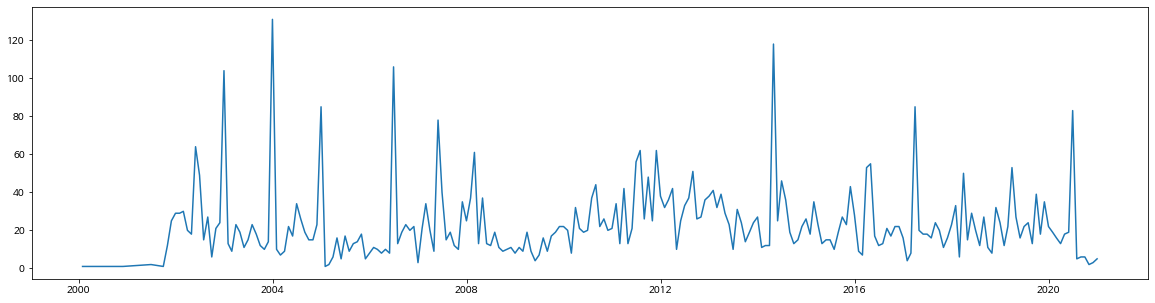

In [10]:
#날자별 line graph 
df_dates = df['처분일자'].value_counts()
dates = df_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates.sort_values(by=['처분일자'])
dates = dates.resample('M').sum()
dates = dates[dates.위반횟수 != 0]

plt.figure(figsize=(20, 5))
plt.plot(dates.index, dates.위반횟수)

업종별 pie chart를 그려보았을 때, `일반음식점`의 비율이 압도적으로 많음을 알 수 있음.<br/>
효과적인 분석을 위해서, 일반음식점과 다른 업종을 구분하여 분석.



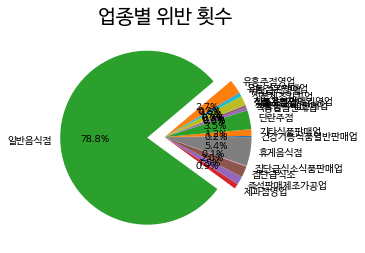

In [11]:
#업종별 pie chart
df_count = df.groupby(by=['업종명'], as_index=False).count()
frequency = df_count['Year'];
label = df_count['업종명'];

plt.title('업종별 위반 횟수', size=20)
plt.rcParams["figure.figsize"] = (10,10)
lst = np.zeros(len(df_count))
lst[12] = 0.2
plt.pie(frequency, labels=label, autopct='%.1f%%', explode=lst)
plt.show()

위반 내용별 bar chart를 그려 보았을 때,`건강진단미필`이 제일 많으며, `광고`가 제일 적음을 알 수 있다.<br/>
기타가 2번째를 차지함을 보아, 이에 포함되지 않는 위반 내용이 상당히 많다는 것을 알 수있다.

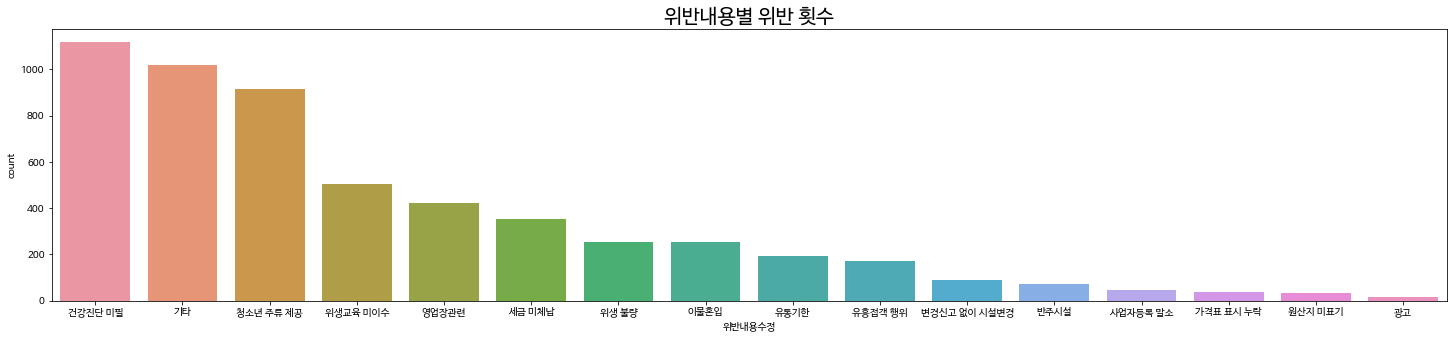

In [12]:
#위반내용별 위반횟수
plt.rcParams["figure.figsize"] = (25, 5)

plt.title('위반내용별 위반 횟수', size=20)
fig = sns.countplot(x ='위반내용수정', data = df, order = df['위반내용수정'].value_counts().index)

처분별 bar chart를 그려 보았을 때, `과태료`가 가장 많고, `과징금`이 제일 적은 것을 알 수 있다.

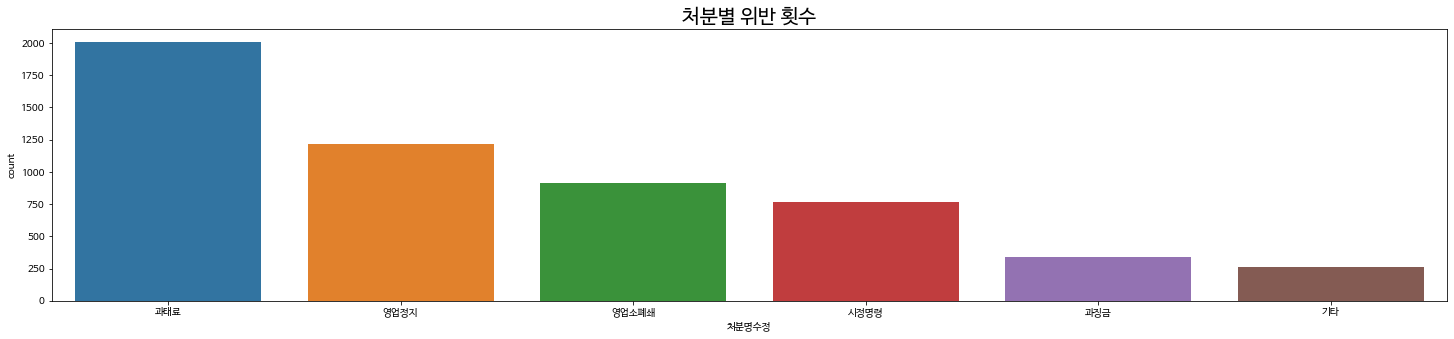

In [13]:
#위반내용별 위반횟수
plt.rcParams["figure.figsize"] = (25, 5)

plt.title('처분별 위반 횟수', size=20)
fig = sns.countplot(x ='처분명수정', data = df, order = df['처분명수정'].value_counts().index)

##4. Data Analysis2

---
전체분석 결과에 따라, 일반음식점과 일반음식점을 제외한 업종을 따로 분석<br/><br/>


*   일반음식점 제외 - 간단하게
*   일반음식점      - 자세히<br/><br/> 



###4-1. 일반음식점 제외

---


*   Data Preprocessing -> `일반음식점`을 제외한 업종 불러옴
*   `업종별`분석
<br/><br/>



In [14]:
#일반음식점을 제외한 데이터 받아옴
dfDropRegular = df[df.업종명 !='일반음식점']
dfDropRegular.head()

,처분일자,업종명,업태명,업소명,Year,위반내용수정,처분명수정
2185,2002-05-01,유흥주점영업,간이주점,보스,2002,기타,시정명령
2186,2010-03-02,유흥주점영업,간이주점,포차 멜로디 노래타운,2010,위생교육 미이수,과태료
2187,2004-06-23,유흥주점영업,룸살롱,무랑루즈비즈니스,2004,기타,시정명령
2188,2018-01-08,유흥주점영업,룸살롱,마이웨이,2018,이물혼입,시정명령
2189,2002-02-01,유흥주점영업,룸살롱,24시유흥주점,2002,유통기한,영업정지


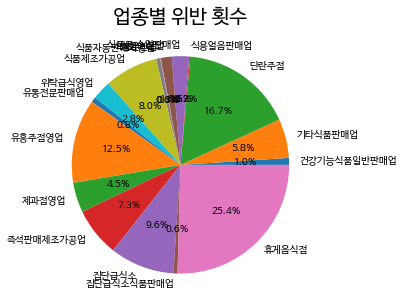

In [15]:
#업종별 pie chart
dfDropRegular_count = dfDropRegular.groupby(by=['업종명'], as_index=False).count()
frequency = dfDropRegular_count['Year'];
label = dfDropRegular_count['업종명'];

plt.title('업종별 위반 횟수', size=20)
plt.rcParams["figure.figsize"] = (10,10)
lst = np.zeros(len(dfDropRegular_count))
plt.pie(frequency, labels=label, autopct='%.1f%%', explode=lst)
plt.show()

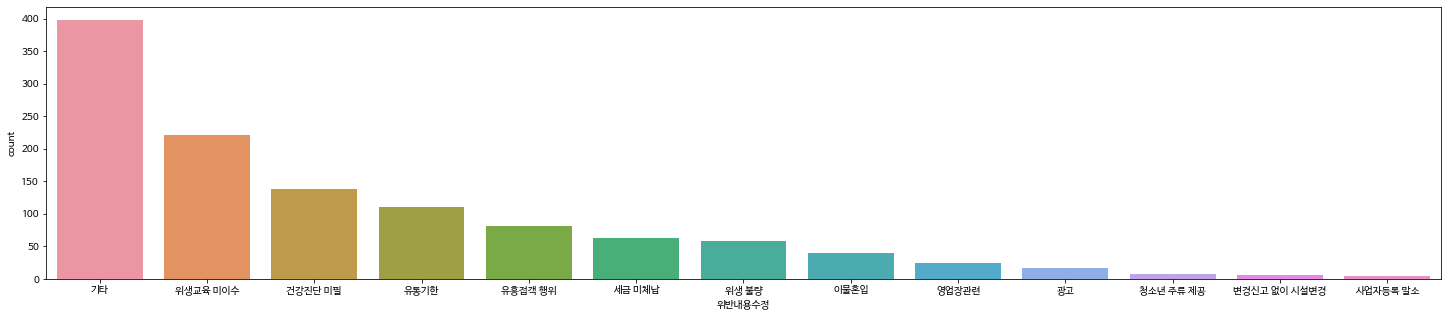

In [16]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='위반내용수정', data = dfDropRegular, order = dfDropRegular['위반내용수정'].value_counts().index)

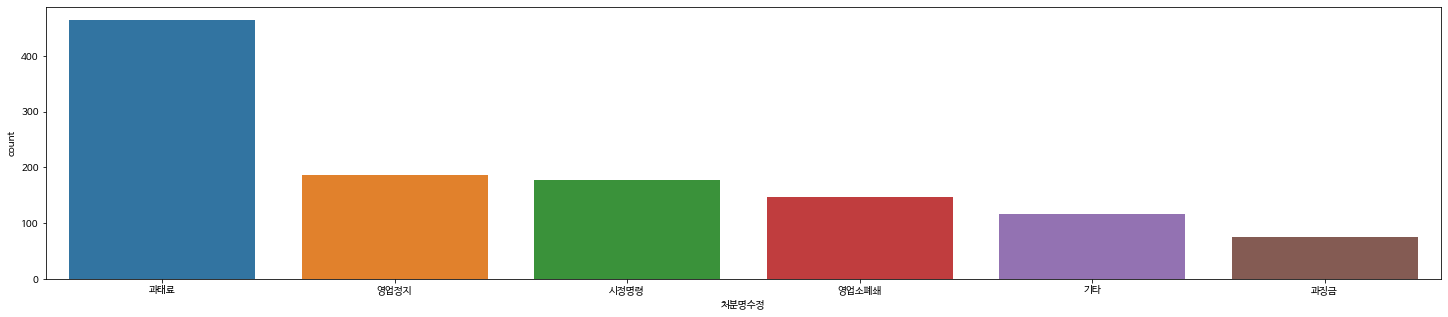

In [17]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='처분명수정', data = dfDropRegular, order = dfDropRegular['처분명수정'].value_counts().index)

###4-2. 일반음식점

---
*   Data Preprocessing -> `일반음식점`만 불러옴
*   ploty를 사용한 Dash Board 생성<br/><br/>

In [18]:
#일반음식점만 가져옴
dfRegular = df[df.업종명 =='일반음식점']
dfRegular.head()

,처분일자,업종명,업태명,업소명,Year,위반내용수정,처분명수정
0,2004-09-14,일반음식점,호프/통닭,원샷,2004,청소년 주류 제공,영업정지
1,2005-09-23,일반음식점,분식,동호,2005,영업장관련,영업정지
2,2007-08-20,일반음식점,분식,동호,2007,영업장관련,시정명령
3,2007-10-18,일반음식점,분식,동호,2007,영업장관련,과징금
4,2005-10-24,일반음식점,분식,천궁,2005,이물혼입,시정명령


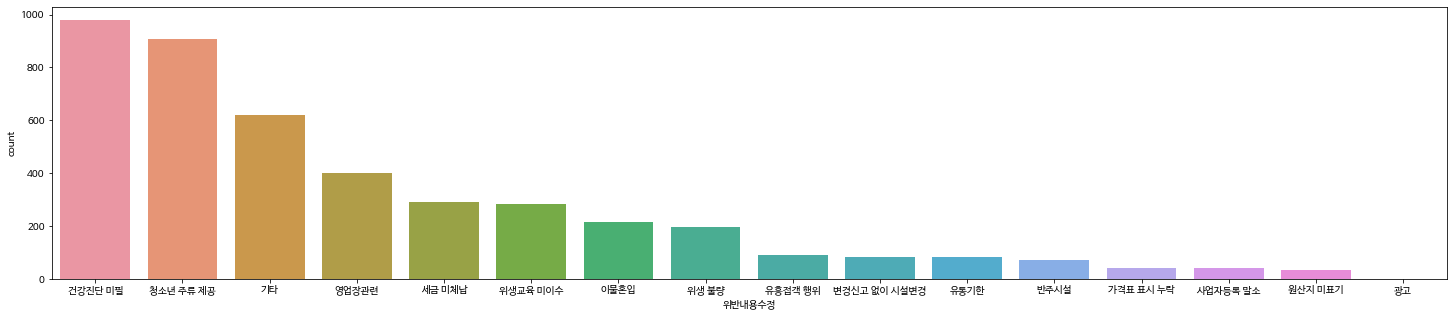

In [19]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='위반내용수정', data = dfRegular, order = dfRegular['위반내용수정'].value_counts().index)

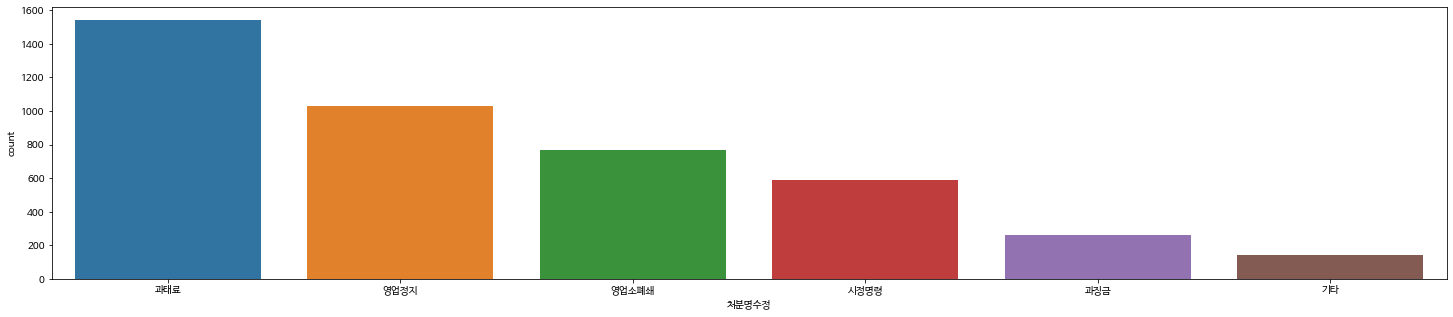

In [20]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='처분명수정', data = dfRegular, order = dfRegular['처분명수정'].value_counts().index)

Ploty와 dash이용해 반응형 시각화

In [21]:
#plotly와 dash

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [22]:
#line test

data_dates = dfRegular['처분일자'].value_counts()
dates = data_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates = dates.resample('M').sum()

fig = go.Figure(data=[go.Scatter(x=dates.index, y=dates['위반횟수'])])

#fig = px.line(x=dates.index, y=dates['위반횟수'])
#fig = px.line(x=dates.index, y=dates.위반횟수)

fig.show()

In [23]:
#pie test

dfRegula_count = dfRegular.groupby(by=['업태명'], as_index=False).count()
frequency = dfRegula_count['Year'];
label = dfRegula_count['업태명'];

fig = go.Figure(data=[go.Pie(labels=label, values=frequency)])
fig.update_traces(textposition='inside')

fig.show()

In [24]:
#bar test

data_dates = dfRegular['처분명수정'].value_counts()
dates = data_dates.to_frame(name='처분명수정')
#dates.index.name = '처분명수정'

#bar color -> https://stackoverflow.com/questions/61892036/plotly-how-to-colorcode-plotly-graph-objects-bar-chart-using-python
k=[15,30,45,60,75,90]
fig = go.Figure(data=[go.Bar(x=dates.index, y=dates['처분명수정'],
                             marker=dict(color = k, colorscale='viridis'))])

fig.show()

전반적인 분석 : 위 3개의 그래프 한눈에 볼 수 있도록 합침



In [25]:
#참고 자료(공식)
#plotly express -> https://plotly.com/python/plotly-express/
#plotly subplot -> https://plotly.com/python/subplots/#multiple-subplots
#plotly line&scatter -> https://plotly.com/python/line-and-scatter/
#plotly piechart -> https://plotly.com/python/pie-charts/

#참고 자료(그외)
#https://tariat.tistory.com/749

#line, pie 들어갈 수 있게 1X2의 figure생성 + bar!
# specs -> https://stackoverflow.com/questions/54975791/how-to-subplot-pie-chart-in-plotly
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'scatter'}, {'type': 'pie', 'rowspan':2}], [{'type':'bar'}, None]],column_widths=[0.7, 0.3],
                    subplot_titles=("연도별 분석","업태별 분석", "처분명 분석"))


#line 데이터 정리
data_dates = dfRegular['처분일자'].value_counts()
dates = data_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates.sort_values(by=['처분일자'])
dates = dates.resample('M').sum()

#line 그래프 그려줌
fig.add_trace(go.Scatter(x=dates.index, y=dates['위반횟수']),
              row=1, col=1)

#line 그래프 x, y축 타이틀 설정
#설정방법 -> https://stackoverflow.com/questions/65779052/how-to-set-axis-label-in-subplots-with-dash/65779105
fig.update_xaxes(title_text="날짜", row=1, col=1)
fig.update_yaxes(title_text="횟수", row=1, col=1)

#pie 데이터 정리
dfRegula_count = dfRegular.groupby(by=['업태명'], as_index=False).count()
frequency = dfRegula_count['Year'];
label = dfRegula_count['업태명'];

#pie 그래프 그려줌
fig.add_trace(go.Pie(labels=label, values=frequency, ),
              row=1, col=2)
fig.update_traces(textposition='inside', row=1, col=2)

#bar 데이터 정리
data_dates = dfRegular['처분명수정'].value_counts()
dates = data_dates.to_frame(name='처분명수정')

#bar 그래프 그려줌
k=[15,30,45,60,75,90]
fig.add_trace(go.Bar(x=dates.index, y=dates['처분명수정'],
                             marker=dict(color = k, colorscale='viridis')),
              row=2, col=1)

fig.show()

위반 내용별 분석 -> Dash Board

In [26]:
#위반 내용별 분석을 위해, '기타'제외한 위반내용 뽑아옴

available_in = dfRegular['위반내용수정'].unique()
available_in = np.delete(available_in, np.where( available_in == '기타'))
available_in

array(['청소년 주류 제공', '영업장관련', '이물혼입', '유통기한', '위생 불량', '건강진단 미필',
       '유흥접객 행위', '세금 미체납', '변경신고 없이 시설변경', '위생교육 미이수', '사업자등록 말소',
       '가격표 표시 누락', '원산지 미표기', '반주시설', '광고'], dtype=object)

대시보드를 통해 위반내용에 따른 분석결과를 확인할 수 있다.<br/><br/>

1. `청소년 주류제공`의 경우 꾸준히 꾸준히 위반됨을 알 수 있고, 한식, 호프/통닭, 분식등 업태도 다양한 것을 알 수 있다.
2. `영업장관련 위반`의 경우는 초분도 다양하며, 업태도 다양한 것을 알 수 있다. 또한 10년대 초반에 대량으로 위반이 확인됨을 알 수 있다.
1. `이물혼입`의 경우, 00년대보다 10년대에 위반횟수가 많아졌고, 대부분 시정명령이 내려온 것을 알 수 있다.
2. `유통기한 위반`의 경우, 영업정지와 과징금이 비슷한 비율이며, 한식이 대부분인 다른 위반항목에 반해 호프/통닭이 가장 많으며, 한식과 비슷한 비율로 위반했음을 알 수 있다.
3. `위생 불량`의 경우, 대부분 과태료 처분이 내려졌고, 최근 걸린 횟수가 증가한 것을 알 수 있다.
4. `건강진단 미필`의 경우는 과태료가 대부분, `시설변경`의 경우는 영업소 폐쇄
5. `유흥접객 행위`의 경우, 과거에 비해 최근엔 줄어들 것을 알수 있고, 주점과 분식의 비율이 제일 많다.
6. `세금미체납`의 경우는 영업소가 폐쇄되는 처분이 내려지며, 보통 12월달에 처분이 내려지는 것을 확인할 수 있다.
7. `위생교육`의 경우는 4,5월에 처분이 내려지며, 최근에 위반횟수가 늘어난 것을 확인할 수있다.
8. `건강진단`의 경우 꾸준하게 위반됨을 확인할 수 있으며, 특히 12년도, 20년도 부근에 늘어남을 확인할 수 있으며 대부분 과태료 처분이 내려진다.
9. `원산지 미표기`의 경우는 대부분 과태료 처분이며, 최근에 위반횟수가 증가했다.
10. `반주시설`의 경우 초근데 증가함을 알 수 있고, 대부분 영업정지, 과징금 처분이 내려오며, 호프/통닭, 경양식, 라이프카페가 대부분이다.

In [27]:
# 참고자료
#4주차 과제 마지막 Dash
#https://medium.com/plotly/introducing-dash-5ecf7191b503
#위 링크 안 소스코드 -> https://gist.github.com/chriddyp/9b2b3e8a6c67697279d3724dce5dab3c

#전체분석과 같은 툴로 대시보드 생성

app = JupyterDash()

app.layout = html.Div(id = 'parent',
    children = [html.H1(id='title', children = '위반 종류별 분석',
                            style = {'textAlign':'center', 'marginTop' : 40, 'marginBottom':40}),

                    dcc.Dropdown(id='dropdown',
                                   options = [{'label':i, 'value':i} for i in available_in],                                              
                                   value='청소년 주류 제공'),
                    dcc.Graph(id = 'plot')
      ])

@app.callback(Output(component_id='plot', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value')])

def graph_update(dropdown_value):
  dfRegular_contents = dfRegular[dfRegular.위반내용수정==dropdown_value]

  fig = make_subplots(rows=2, cols=2, specs=[[{'type':'scatter'}, {'type': 'pie', 'rowspan':2}], [{'type':'bar'}, None]],column_widths=[0.7, 0.3],
                      subplot_titles=("연도별 분석","업태별 분석", "처분명 분석"))


  #line 데이터 정리
  data_dates = dfRegular_contents['처분일자'].value_counts()
  dates = data_dates.to_frame(name='위반횟수')
  dates.index.name = '처분일자'
  dates.sort_values(by=['처분일자'])
  dates = dates.resample('M').sum()

  #line 그래프 그려줌
  fig.add_trace(go.Scatter(x=dates.index, y=dates['위반횟수']),
                row=1, col=1)

  #line 그래프 x, y축 타이틀 설정
  fig.update_xaxes(title_text="날짜", row=1, col=1)
  fig.update_yaxes(title_text="횟수", row=1, col=1)

  #pie 데이터 정리
  dfRegula_count = dfRegular_contents.groupby(by=['업태명'], as_index=False).count()
  frequency = dfRegula_count['Year'];
  label = dfRegula_count['업태명'];

  #pie 그래프 그려줌
  fig.add_trace(go.Pie(labels=label, values=frequency, ),
                row=1, col=2)
  fig.update_traces(textposition='inside', row=1, col=2)

  #bar 데이터 정리
  data_dates = dfRegular_contents['처분명수정'].value_counts()
  dates = data_dates.to_frame(name='처분명수정')

  #bar 그래프 그려줌
  k=[15,30,45,60,75,90]
  fig.add_trace(go.Bar(x=dates.index, y=dates['처분명수정'],
                               marker=dict(color = k, colorscale='viridis')),
                row=2, col=1)
  
  return fig 

if __name__ == '__main__': 
    app.run_server()

Dash app running on:


<IPython.core.display.Javascript object>

##5. Learning Mahnine
###Multiple Linear Regression

---

* 데이터가 모두 text형태이기 때문에 encoding
* `위반내용` `처분명` `업태명`으로 어느 업종인지 예측할 수 있는 모델<br/><br/>

In [28]:
#encoding

df.loc[:, '위반내용_encoding'] = pd.factorize(df['위반내용수정'])[0].reshape(-1, 1)
df.loc[:, '처분명_encoding'] = pd.factorize(df['처분명수정'])[0].reshape(-1, 1)
df.loc[:, '업종명_encoding'] = pd.factorize(df['업종명'])[0].reshape(-1, 1)
df.loc[:, '업태명_encoding'] = pd.factorize(df['업태명'])[0].reshape(-1, 1)
df

,처분일자,업종명,업태명,업소명,Year,위반내용수정,처분명수정,위반내용_encoding,처분명_encoding,업종명_encoding,업태명_encoding
0,2004-09-14,일반음식점,호프/통닭,원샷,2004,청소년 주류 제공,영업정지,0,0,0,0
1,2005-09-23,일반음식점,분식,동호,2005,영업장관련,영업정지,1,0,0,1
2,2007-08-20,일반음식점,분식,동호,2007,영업장관련,시정명령,1,1,0,1
3,2007-10-18,일반음식점,분식,동호,2007,영업장관련,과징금,1,2,0,1
4,2005-10-24,일반음식점,분식,천궁,2005,이물혼입,시정명령,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5630,2011-07-15,집단급식소식품판매업,집단급식소 식품판매업,(주)선명푸드,2011,기타,과징금,6,2,15,53
5631,2010-11-08,건강기능식품일반판매업,전자상거래(통신판매업),유산균천사,2010,광고,영업정지,15,0,16,55
5632,2014-04-25,건강기능식품일반판매업,영업장판매,허브 앤 펫,2014,광고,영업정지,15,0,16,54
5633,2014-03-24,건강기능식품일반판매업,영업장판매,허브모아,2014,광고,영업정지,15,0,16,54


세 변수의 연관도를 알아보기 위한 pairplot<br/>
거의다 퍼져서 분포하지만, incodeing결과가 Ordinal이므로 뭉쳐있을시 판단 어려움

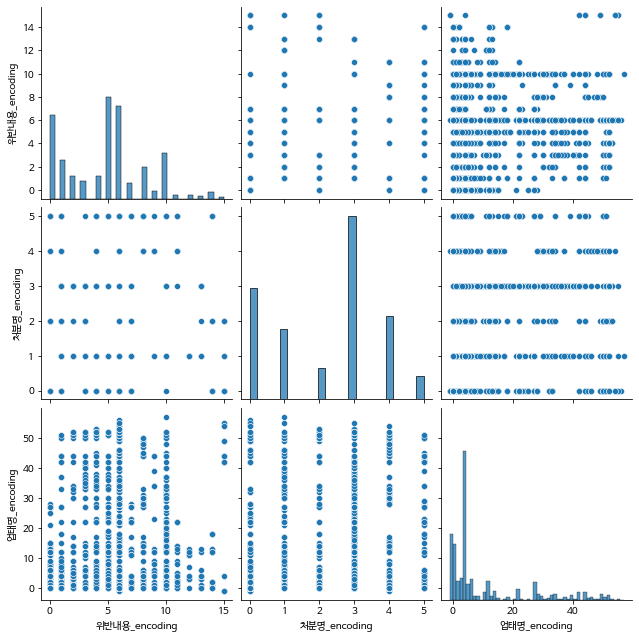

In [29]:
#incoding한 결과의 pairplot

sns.pairplot(data=df[['위반내용_encoding', '처분명_encoding', '업태명_encoding']], height=3)

실행할 때 마다 결과가 바뀌기 때문에 random_state로 나누는 랜덤값 고정.

In [30]:
#업종명 찾는 Regression
#8주차 과제, 추가참고 -> https://hleecaster.com/ml-linear-regression-example/

X = df[['위반내용_encoding', '처분명_encoding', '업태명_encoding']]
y = df.업종명_encoding

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [35]:
# Multiple linear regression

from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, y_train)
y_prediction =  LR.predict(X_test)

In [36]:
#변수 4개 이므로 그래프그리기 불가능 -> coefficient찾는것으로 대체

print('Coefficient')
print('위반내용 : %.4f'%LR.coef_[0])
print('처분명 : %.4f'%LR.coef_[1])
print('업태명 : %.4f'%LR.coef_[2])

Coefficient
위반내용 : -0.0392
처분명 : 0.0035
업태명 : 0.1682


In [37]:
#Evaluating
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_test,y_prediction)

print('정확도 : %.4f'%score)

정확도 : 0.7650
